# On Animal Outcomes in Austin Shelters

This survey evaluates the potential to predict adoption outcomes for animals entering the Austin Animal Center shelter system and examines the implications of these findings.

### Table of Contents:

- Part I: Introduction
- Part II: Preprocessing Summary
- Part III: Predictive Models and Relevant Findings
- Part IV: Conclusion

## Part I: Introduction

Pet shelters by their nature face enormous pressure to care for and to effect the ultimate wellbeing of animals brought into their care, and to save as many animals as possible. One challenge this creates is capacity management, as shelters have limited space and resources to allocate for this purpose. For these reason, a thorough understanding of the shelter system and of outcome likelihoods for the animals in question is necessary for the fulfillment of its central mission, because it allows a shelter to manage capacity efficiently, both to maximize the potential for adopting out certain animals quickly and for better planning to help as many "hard cases" as circumstances allow.

This project seeks primarily to meet this need through the development of the strongest model possible in terms of its predictive power as related to an animal's ultimate outcome (i.e. whether or not an animal will be adopted). With such a model fine-tuned to the needs of this or that shelter, how many more animals might saved and found forever homes?

## Part II: Preprocessing Summary

The process began with two datasets taken from the Austin Animal Center, one for intake information (or an animal's information upon being brought into the shelter system) and one for outcome information (information pertaining to an animal's being adopted, returned to owner, euthanized, and so on). 

The first step of preprocessing was to omit problematic/erroneous entries from each dataset. Then columns entered as strings were converted where possible to more model-friendly numeric values, and many features were engineered to experiment with anything that might prove useful for the predictive model. The final step was to merge the Intakes and Outcomes datasets, so that each stay of an animal at last consisted of a single entry in the final dataframe.

This process is recorded in `01_initial_cleaning.ipynb`, `02_initial_eda.ipynb`, and `03_master_data_prep.ipynb` in the `appendices/appendix_01_preprocessing` folder.

Once the datasets were merged this allowed for additional exploration, found in `04_additional_eda.ipynb` in the same folder.

## Part III: Predictive Models and Relevant Findings

The final model as it exists in the corresponding StreamLit app filters information entered by the user first based on `intake_type` (that is, the circumstances surrounding an animal's being brought into the shelter), and this determines which version of the model will fit the data when predicting whether or not the animal in question will be adopted. During the modeling process, this allowed for the most accurate results.

A more detailed notebook accounting for all the nuances of the model is named `01_models.ipynb` and is found in `appendices/appendix_02_modeling`.

As mentioned elsewhere, This notebook does not by itself reflect the robust comprehensiveness of the project team's efforts to find the most apropos model(s) possible. Much time went into attempting the construction of a model that predicted the duration of an animal's stay before their being adopted, but results were weak, at least for these datasets. Additionally, the team fit the data to multiclass predictive models, and these performed consistently well, but were of somewhat less relevance to the project at hand.

Many of these exhaustive efforts are recording in the collection of notebooks gathered in the `scrap` folder.

Below is a demonstration of the model's functionality using entries for perhaps one of the most salient intake types--that is, strays.

Imports, setting the random seed, and dataset read-in:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

np.random.seed(13)
df = pd.read_csv('datasets/model_frame.csv')

Binarization of the target column and some cleanup:

In [3]:
df['adopted'] = (df['outcome_type'] == 'Adoption').map({True: 1, False:0})

df.drop(columns=['outcome_type'], inplace=True)
df['month_in'] = df['month_in'].astype(str)

One-hot encoding has a large role in the final model as a result of the many categorical features that needed conversion to be made meaningful. Below, categorical features are encoded and the dataset is re-merged:

In [4]:
# get our numeric columns
numeric = df.select_dtypes(exclude=object)

# get our categorical columns
categorical = df.select_dtypes([object])

# preserve the names of our categorical data
categorical_fnames = categorical.dtypes.keys() # preserve the names

# make sure you are importing one hot encoder, or this function will not work
enc = OneHotEncoder(sparse=False)

# categorical is now an array of arrays 
categorical = enc.fit_transform(categorical) 

dummy_cat_names = enc.get_feature_names(categorical_fnames)

categorical_df = pd.DataFrame(categorical, columns=dummy_cat_names)

df = pd.concat([numeric, categorical_df], axis=1)

Dataframe filters to include only animals brought in as strays:

In [5]:
model_df = df[df['intake_type_Stray'] == 1]
model_df.reset_index(inplace=True, drop=True)

Baseline accuracy score in the cell below:

In [6]:
print(model_df['adopted'].value_counts(normalize=True))

0    0.550385
1    0.449615
Name: adopted, dtype: float64


Features are divvied up as inputs or as the target variable:

In [7]:
features = (model_df.drop(columns = ['adopted']).columns)
X = model_df[features]
y = model_df['adopted']

A standard train-test-split:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

A pipeline scales the training data and fits it to our final Gradient Boost Classifier model:

In [9]:
pipe_params = [
  ('scaler', StandardScaler()),
  ('gbc', GradientBoostingClassifier(random_state=13))
]
stray_pipe = Pipeline(pipe_params)
stray_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbc', GradientBoostingClassifier(random_state=13))])

Training and test scores show that the model is fit well and outperforms the baseline by a mile. Mission accomplished.

In [10]:
print('Training Score: ', stray_pipe.score(X_train, y_train))
print('Testing Score: ', stray_pipe.score(X_test, y_test))

Training Score:  0.8328847084442293
Testing Score:  0.8286077212720592


For good measure, a final confusion matrix to outline the model's performance:

              precision    recall  f1-score   support

           0       0.92      0.76      0.83     12132
           1       0.75      0.92      0.83      9911

    accuracy                           0.83     22043
   macro avg       0.84      0.84      0.83     22043
weighted avg       0.84      0.83      0.83     22043



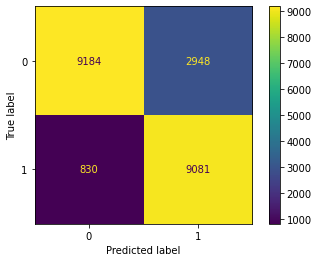

In [11]:
plot_confusion_matrix(stray_pipe, X_test, y_test);
print(classification_report(y_test, stray_pipe.predict(X_test)))

## Part IV: Conclusion

Ultimately, the project team was successful in crafting a model that performs well above the baseline when predicting whether or not an animal is adopted. Key variables include duration of stay and animal age. As the duration of stay increases, so too does likelihood of adoption. As age increases, adoption likelihood decreases.